In [1]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [70]:
columns_labels = [ 'Device ID', 'accelerometer x', 'accelerometer y', 'accelerometer z',
    'gyroscope x', 'gyroscope y', 'gyroscope z', 'magnetometer x', 'magnetometer y', 'magnetometer z',
    'Timestamp', 'Activity Label']

activities = np.array(['Stand', 'Sit', 'Sit and Talk', 'Walk', 'Walk and Talk', 'Climb Stair (up/down)',
    'Climb Stair (up/down) and talk', 'Stand -> Sit', 'Sit -> Stand', 'Stand -> Sit and talk', 'Sit -> Stand and talk',
    'Stand -> walk', 'Walk -> stand', 'Stand -> climb stairs (up/down)(and talk)', 'Climb stairs (up/down) -> walk',
    'Climb stairs (up/down) and talk -> walk and talk'])

### 2. Read Files

In [108]:
from dis import dis


def readFiles(devi):
    dev = [0]*15
    for id in range(15):
        file = "part" + str(id)
        pasta = "dataset\part" + str(id)

        f = file + "dev" + str(devi) + ".csv"
        dir = os.path.join(pasta, f)
        dev[id] = np.genfromtxt(dir, delimiter=',')

    dFrame = pd.DataFrame(np.concatenate(dev), columns=columns_labels)
    labels = activities[dFrame['Activity Label'].astype(int)-1]
    dFrame['Label Name'] = labels
    display(dFrame)

    return [np.concatenate(dev), dFrame]

[data, dataFrame] = readFiles(2)

,Device ID,accelerometer x,accelerometer y,accelerometer z,gyroscope x,gyroscope y,gyroscope z,magnetometer x,magnetometer y,magnetometer z,Timestamp,Activity Label,Label Name
0,2.0,3.0317,9.0450,3.1739,0.76247,3.7071,-0.31384,0.57764,0.68849,1.2654,63.629,1.0,Stand
1,2.0,2.9591,9.0436,3.1400,0.40588,4.6682,-0.10148,0.58385,0.68849,1.2741,83.160,1.0,Stand
2,2.0,2.9465,9.0545,3.0799,0.24230,5.5225,0.34857,0.56522,0.67857,1.2675,102.690,1.0,Stand
3,2.0,2.7898,9.0528,3.0726,0.49858,6.3463,0.61127,0.56108,0.65476,1.2610,122.220,1.0,Stand
4,2.0,2.6924,9.0377,2.9794,0.63197,6.6972,1.00560,0.57764,0.69246,1.2675,141.750,1.0,Stand
...,...,...,...,...,...,...,...,...,...,...,...,...,...
781817,2.0,1.6802,9.5395,2.9636,0.83324,1.9832,0.87140,-0.38716,0.87103,1.3289,1042000.000,1.0,Stand
781818,2.0,1.7042,9.5639,2.9504,1.03060,1.8002,0.54192,-0.37474,0.86508,1.3399,1042000.000,1.0,Stand
781819,2.0,1.7283,9.5641,2.9496,1.05330,1.3577,0.89447,-0.35818,0.92857,1.3531,1042000.000,1.0,Stand
781820,2.0,1.7285,9.5646,2.9737,1.03550,1.4340,0.78856,-0.36232,0.90675,1.3377,1042000.000,1.0,Stand


### 3. Módulo

In [109]:
def modulo(dFrame):

    for i in range(16):
        acc = np.sqrt(dFrame['accelerometer x']**2 + dFrame['accelerometer y']**2 + dFrame['accelerometer z']**2)
        gir = np.sqrt(dFrame['gyroscope x']**2 + dFrame['gyroscope y']**2 + dFrame['gyroscope z']**2)
        mag = np.sqrt(dFrame['magnetometer x']**2 + dFrame['magnetometer y']**2 + dFrame['magnetometer z']**2)

    data = pd.DataFrame({'ID': dFrame['Device ID'], 'Acc': acc, 'Gyr': gir, 'Mag': mag, 
                            'Label ID': dFrame['Activity Label'], 'Label Name': dFrame['Label Name']})

    display(data)

    return data

mod_data = modulo(dataFrame)

,ID,Acc,Gyr,Mag,Label ID,Label Name
0,2.0,10.053699,3.797690,1.552071,1.0,Stand
1,2.0,10.020108,4.686910,1.561483,1.0,Stand
2,2.0,10.007578,5.538792,1.544826,1.0,Stand
3,2.0,9.958767,6.395135,1.527626,1.0,Stand
4,2.0,9.889685,6.801699,1.555547,1.0,Stand
...,...,...,...,...,...,...
781817,2.0,10.129564,2.320928,1.635409,1.0,Stand
781818,2.0,10.152701,2.143953,1.638330,1.0,Stand
781819,2.0,10.156730,1.937232,1.679707,1.0,Stand
781820,2.0,10.164260,1.936606,1.656174,1.0,Stand


### 3.1 Boxplot dos módulos

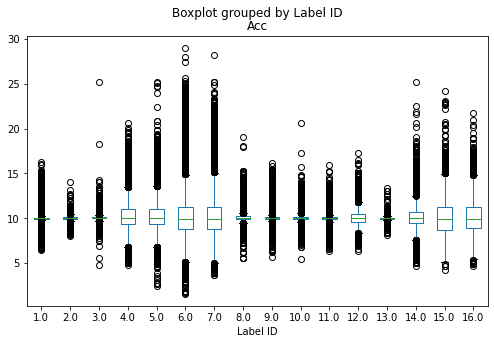

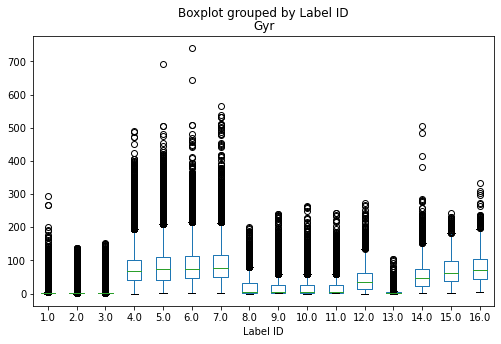

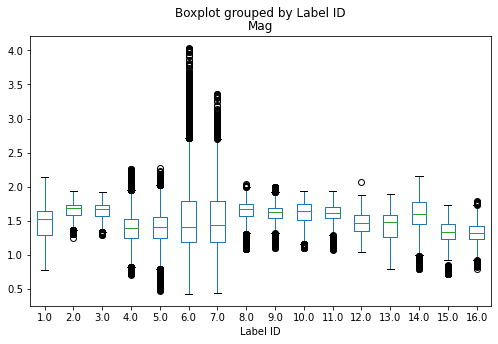

In [110]:
def boxplot(mod_data):
    mod_data.boxplot(by ='Label ID', column =['Acc'], grid = False, figsize=(8,5))
    mod_data.boxplot(by ='Label ID', column =['Gyr'], grid = False, figsize=(8,5))
    mod_data.boxplot(by ='Label ID', column =['Mag'], grid = False, figsize=(8,5))

boxplot(mod_data)